In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.models import load_model


In [2]:
load_chest_x_ray_model=load_model("chest_x_ray_model")

In [3]:
load_chest_x_ray_model

In [4]:
#the fast gradient sign method (FGSM) Untargeted method
#https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
def adversarial_pattern_FGSM(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = load_chest_x_ray_model(tf.expand_dims(image,axis=0))
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [5]:
def perturbations_FGSM_generator(image,model):
    image_probs=model.predict(tf.expand_dims(image,axis=0))
    image_pred_index=image_probs.argmax()
    label = tf.one_hot(image_pred_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))
    return adversarial_pattern_FGSM(image, label).numpy()

In [6]:
class_names=['COVID19', 'NORMAL', 'PNEUMONIA']


In [7]:
def load_and_prep_image(filename, img_shape=224, scale=False):
  
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [8]:
normal_image=load_and_prep_image(filename="NORMAL(0).jpg",scale=False)

1/1 [==============================] - 3s 3s/step
1


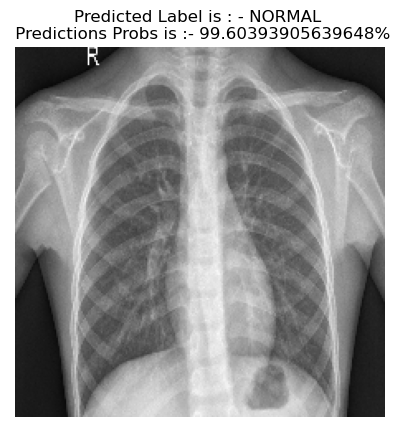

In [9]:
plt.imshow(normal_image/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(normal_image,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n Predictions Probs is :- {prob.max()*100}%")
plt.axis(False)
print(prob.argmax())

In [10]:
perturbations_FGSM = perturbations_FGSM_generator(normal_image,load_chest_x_ray_model)


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Perturbation Normal')

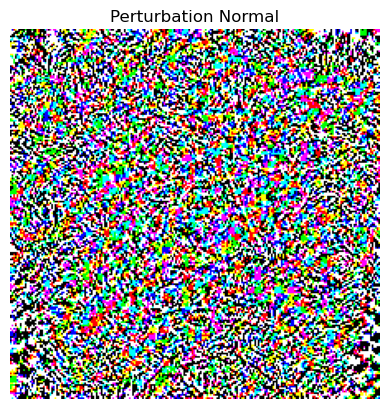

In [11]:
plt.imshow(perturbations_FGSM)
plt.axis(False)
plt.title("Perturbation Normal")

In [12]:
adversarial_image = normal_image + perturbations_FGSM *2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 32ms/step


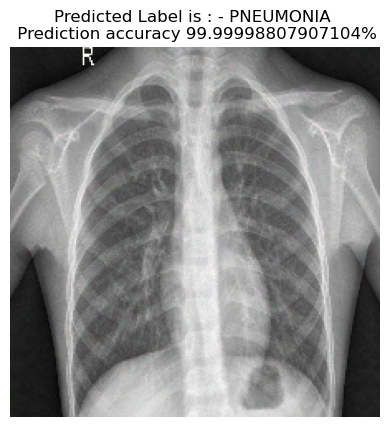

In [13]:
plt.imshow(adversarial_image/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(adversarial_image,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n Prediction accuracy {prob.max()*100}%")
plt.axis(False)
tf.keras.preprocessing.image.save_img('normal_adversarial_image.jpg',adversarial_image)

In [14]:
import cv2
import numpy as np

In [15]:
normal_adversarial_image = cv2.imread("normal_adversarial_image.jpg")


In [16]:
def perform_nlm_denoising(img):
    """
    return NLM image
    """
    nlm = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    
    return np.clip(nlm, 0, 255).astype(np.uint8)

In [17]:
denoised_normal_image = perform_nlm_denoising(normal_adversarial_image)
cv2.imwrite('denoised_normal_image.jpg', denoised_normal_image)


True

In [18]:
denoised_normal_image=load_and_prep_image("denoised_normal_image.jpg")

1/1 [==============================] - 0s 33ms/step


(-0.5, 223.5, 223.5, -0.5)

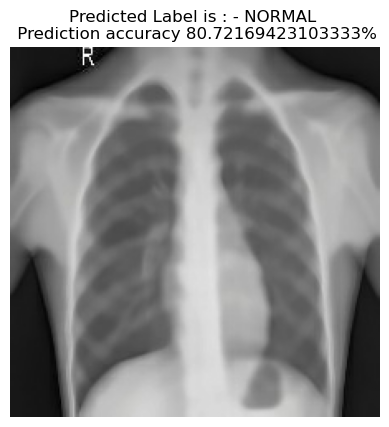

In [19]:
plt.imshow(denoised_normal_image/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(denoised_normal_image,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n Prediction accuracy {prob.max()*100}%")
plt.axis(False)

In [20]:
#Perform Non-Local Means denoising on input image + bilateralFilter + guidedFilter
from cv2.ximgproc import guidedFilter

def perform_nlm_denoising_fun(in_img):
    """
    return NLM image
    """
    img = cv2.imread(in_img)
    nlm = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    denoised = nlm 
    return np.clip(denoised, 0, 255).astype(np.uint8)

def bilateral_filter_and_guided_filter_denoising(in_img):
    """
    return bilateral filter and guided filter denoising
    #https://github.com/lllyasviel/AdverseCleaner
    """
    
    img = cv2.imread(in_img).astype(np.float32)
    y = img.copy()
    
    for _ in range(64):
        y = cv2.bilateralFilter(y, 5, 8, 8)

    for _ in range(4):
        y = guidedFilter(img, y, 4, 16)

    return y.clip(0, 255).astype(np.uint8)

def save__denoised_image(image_path, img):
    """
    save the image
    """
    cv2.imwrite(image_path, img.clip(0, 255).astype(np.uint8))

def combined_denoise_filter_by_somya(in_adv_img_name,out_adv_img_name):
    
    
    # Perform bfgf denoising
    bf_gf = bilateral_filter_and_guided_filter_denoising(in_img=in_adv_img_name)
    cv2.imwrite('bf_gf.jpg', bf_gf)
    #perform nlm denoising
    nlm_denoised = perform_nlm_denoising_fun('bf_gf.jpg')
    
    # Save the denoised image
    save__denoised_image(out_adv_img_name,nlm_denoised)

In [21]:
combined_denoise_filter_by_somya(in_adv_img_name="normal_adversarial_image.jpg",out_adv_img_name="denoised_adv_normal_image.jpg")

In [22]:
denoised_adv_normal_image=load_and_prep_image("denoised_adv_normal_image.jpg",scale=False)

1/1 [==============================] - 0s 33ms/step


(-0.5, 223.5, 223.5, -0.5)

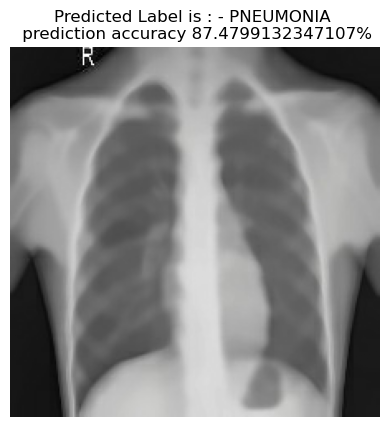

In [23]:
plt.imshow(denoised_adv_normal_image/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(denoised_adv_normal_image,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n prediction accuracy {prob.max()*100}%")
plt.axis(False)

In [24]:
covid19_image=load_and_prep_image(filename="COVID19(0).jpg",scale=False)

In [25]:
normal_image.shape

TensorShape([224, 224, 3])

In [26]:
covid19_image.shape

TensorShape([224, 224, 1])

So we need to convert grayscale covid 19 image to rgb for classifying as our model was built using 3 colour channels aka RGB

In [27]:
covid19_image=tf.image.grayscale_to_rgb(covid19_image)

1/1 [==============================] - 0s 32ms/step
0


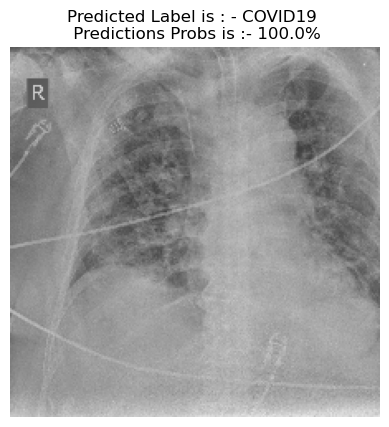

In [28]:
plt.imshow(covid19_image/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(covid19_image,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n Predictions Probs is :- {prob.max()*100}%")
plt.axis(False)
print(prob.argmax())

In [29]:
perturbations_FGSM = perturbations_FGSM_generator(covid19_image,load_chest_x_ray_model)


1/1 [==============================] - 0s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Perturbation Covid 19')

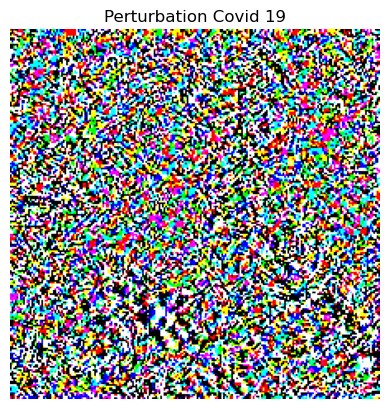

In [30]:
plt.imshow(perturbations_FGSM)
plt.axis(False)
plt.title("Perturbation Covid 19")

In [31]:
adversarial_image = covid19_image + perturbations_FGSM *4.5

1/1 [==============================] - 0s 31ms/step


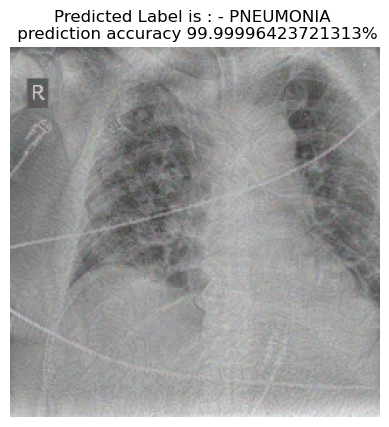

In [32]:
plt.imshow(adversarial_image/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(adversarial_image,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n prediction accuracy {prob.max()*100}%")
plt.axis(False)
tf.keras.preprocessing.image.save_img('manipulated_covid19_image.jpg',adversarial_image)


In [33]:
##combining all

In [34]:
# Load the noisy image
img = cv2.imread('manipulated_covid19_image.jpg')

# Perform ensemble denoising
denoised = perform_nlm_denoising(img)

# Save the denoised image
cv2.imwrite('denoised_nlm_covid19_image.jpg', denoised)

True

In [35]:
denoised_nlm_covid19_image=load_and_prep_image("denoised_nlm_covid19_image.jpg",scale=False)

1/1 [==============================] - 0s 30ms/step


(-0.5, 223.5, 223.5, -0.5)

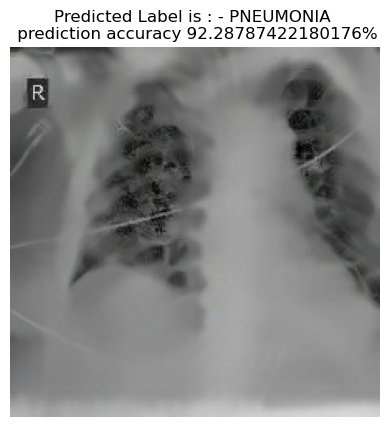

In [36]:
plt.imshow(denoised_nlm_covid19_image/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(denoised_nlm_covid19_image,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n prediction accuracy {prob.max()*100}%")
plt.axis(False)

Above we could see that only NLM filter didnt work out well so lets try NLM+BF+GF

In [37]:
combined_denoise_filter_by_somya(in_adv_img_name='manipulated_covid19_image.jpg',out_adv_img_name="denoised_adv_covid19_image.jpg")

In [38]:
denoised_adv_covid19_image=load_and_prep_image("denoised_adv_covid19_image.jpg",scale=False)

1/1 [==============================] - 0s 31ms/step


(-0.5, 223.5, 223.5, -0.5)

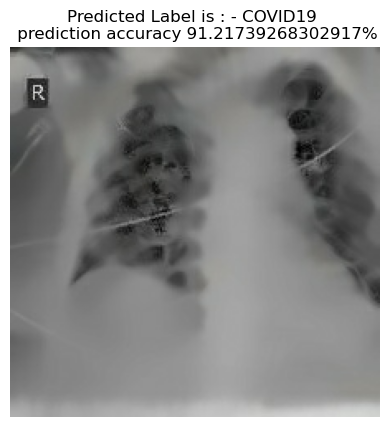

In [39]:
plt.imshow(denoised_adv_covid19_image/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(denoised_adv_covid19_image,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n prediction accuracy {prob.max()*100}%")
plt.axis(False)

In [40]:
pneumonia_image=load_and_prep_image("PNEUMONIA(0).jpg",scale=False)

In [41]:
pneumonia_image.shape #its already a coloured pic

TensorShape([224, 224, 3])

1/1 [==============================] - 0s 33ms/step
2


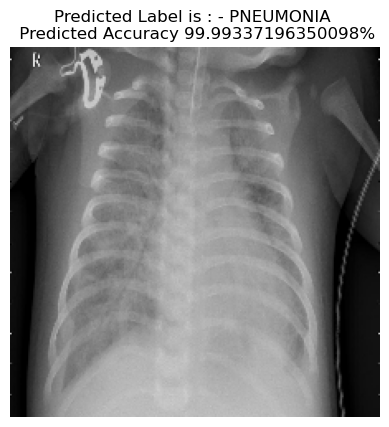

In [42]:
plt.imshow(pneumonia_image/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(pneumonia_image,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n Predicted Accuracy {prob.max()*100}%")
plt.axis(False)
print(prob.argmax())

In [43]:
perturbations = perturbations_FGSM_generator(pneumonia_image,load_chest_x_ray_model)

1/1 [==============================] - 0s 32ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Perturbation Pneumonia')

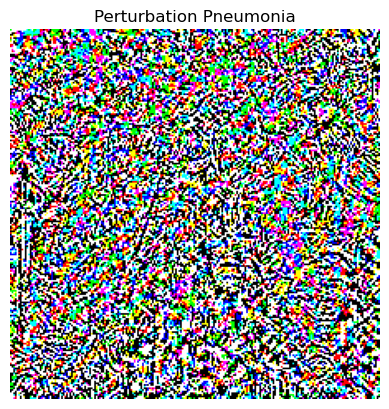

In [44]:
plt.imshow(perturbations)
plt.axis(False)
plt.title("Perturbation Pneumonia")

In [45]:
adversarial_image_pneumonia = pneumonia_image + perturbations *10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 34ms/step


(-0.5, 223.5, 223.5, -0.5)

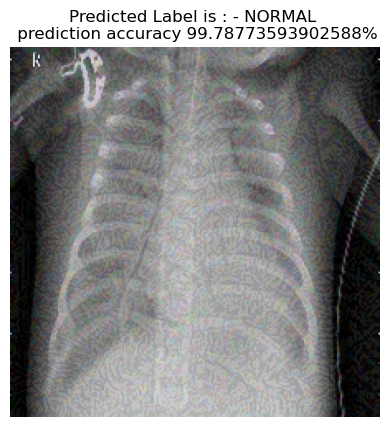

In [46]:
plt.imshow(adversarial_image_pneumonia/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(adversarial_image_pneumonia,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n prediction accuracy {prob.max()*100}%")
plt.axis(False)

In [47]:
tf.keras.preprocessing.image.save_img('manipulated_pneumonia_image.jpg',adversarial_image_pneumonia)


In [48]:
# Load the noisy image
img = cv2.imread('manipulated_pneumonia_image.jpg')

# Perform ensemble denoising
denoised = perform_nlm_denoising(img)

# Save the denoised image
cv2.imwrite('denoised_pneumonia_nlm_image.jpg', denoised)

True

In [49]:
denoised_pneumonia_nlm_image=load_and_prep_image("denoised_pneumonia_nlm_image.jpg",scale=False)

1/1 [==============================] - 0s 30ms/step


(-0.5, 223.5, 223.5, -0.5)

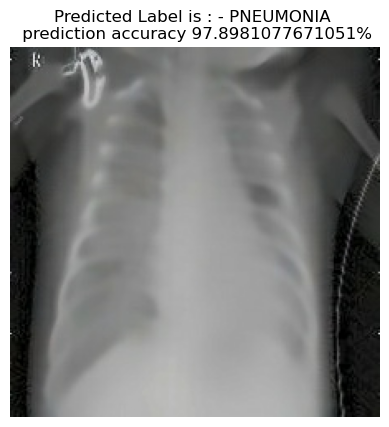

In [50]:
plt.imshow(denoised_pneumonia_nlm_image/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(denoised_pneumonia_nlm_image,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n prediction accuracy {prob.max()*100}%")
plt.axis(False)

In [51]:
combined_denoise_filter_by_somya(in_adv_img_name="denoised_pneumonia_nlm_image.jpg",out_adv_img_name="denoised_adv_pneumonia_nlm_bf_gf_image.jpg")

In [52]:
denoised_adv_pneumonia_nlm_bf_gf_image=load_and_prep_image("denoised_adv_pneumonia_nlm_bf_gf_image.jpg",scale=False)

1/1 [==============================] - 0s 35ms/step


(-0.5, 223.5, 223.5, -0.5)

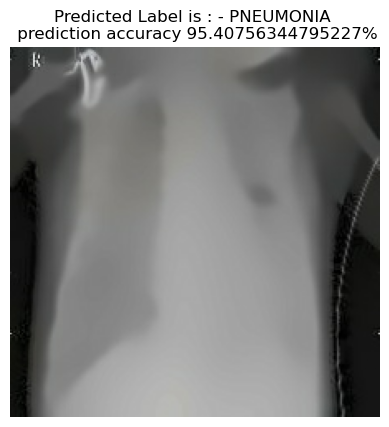

In [53]:
plt.imshow(denoised_adv_pneumonia_nlm_bf_gf_image/255.)
prob=load_chest_x_ray_model.predict(tf.expand_dims(denoised_adv_pneumonia_nlm_bf_gf_image,axis=0))
pred_class=class_names[prob.argmax()]
plt.title(f"Predicted Label is : - {pred_class} \n prediction accuracy {prob.max()*100}%")
plt.axis(False)